In [1]:
#Imports
import numpy as np
import pandas as pd
import datetime as dt
import collections
from datetime import date
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy import stats as sps
from scipy.interpolate import interp1d

In [2]:
# Definimos los parámetros globales a utilizarse

# Creamos un array para cada posible valor de Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Mejor sigma para Peru(prior hyperparameters)
OPTIMAL_SIGMA = 0.01

# Gamma es 1/serial Intervalo
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

In [3]:
def read_and_filter_data():
    # Leer archivo
    direc='https://cloud.minsa.gob.pe/s/Y8w3wHsEdYQSZRp/download'
    # Cargar datos
    df = pd.read_csv(direc, sep=',', encoding='latin-1',squeeze=True).sort_index()
    # Filtrar por departamento
    df2 = df[df['DEPARTAMENTO']=='PIURA']
    # Filtrar los datos que nos interesan
    df3=df2[df2['DISTRITO']!='EN INVESTIGACIÓN']
    # Filtrar por provincia
    df4=df3[df3['PROVINCIA']=='PIURA']
    # Filtrar datos nulos de las fechas
    df5=df4[df['FECHA_RESULTADO'].notna()]
    # Seleccionar solo los campos: distrito y Fecha de resultado
    df6=df5[['DISTRITO', 'FECHA_RESULTADO']]
    
    # Filtramos por distrito
    dfLASL=df6[df6['DISTRITO']=='LAS LOMAS']
    dfCAST=df6[df6['DISTRITO']=='CASTILLA']
    dfPIUR=df6[df6['DISTRITO']=='PIURA']
    dfVEIN=df6[df6['DISTRITO']=='VEINTISEIS DE OCTUBRE']
    dfTAMB=df6[df6['DISTRITO']=='TAMBO GRANDE']
    dfCATA=df6[df6['DISTRITO']=='CATACAOS']
    dfLAUN=df6[df6['DISTRITO']=='LA UNION']
    dfLAAR=df6[df6['DISTRITO']=='LA ARENA']
    dfCURA=df6[df6['DISTRITO']=='CURA MORI']
    dfELTA=df6[df6['DISTRITO']=='EL TALLAN']
    
    # Contamos la cantidad por distrito y convertimos en un dataframe
    ctaLASL = pd.DataFrame(collections.Counter(dfLASL['FECHA_RESULTADO']).most_common())
    ctaCAST = pd.DataFrame(collections.Counter(dfCAST['FECHA_RESULTADO']).most_common())
    ctaPIUR = pd.DataFrame(collections.Counter(dfPIUR['FECHA_RESULTADO']).most_common())
    ctaVEIN = pd.DataFrame(collections.Counter(dfVEIN['FECHA_RESULTADO']).most_common())
    ctaTAMB = pd.DataFrame(collections.Counter(dfTAMB['FECHA_RESULTADO']).most_common())
    ctaCATA = pd.DataFrame(collections.Counter(dfCATA['FECHA_RESULTADO']).most_common())
    ctaLAUN = pd.DataFrame(collections.Counter(dfLAUN['FECHA_RESULTADO']).most_common())
    ctaLAAR = pd.DataFrame(collections.Counter(dfLAAR['FECHA_RESULTADO']).most_common())
    ctaCURA = pd.DataFrame(collections.Counter(dfCURA['FECHA_RESULTADO']).most_common())
    ctaELTA = pd.DataFrame(collections.Counter(dfELTA['FECHA_RESULTADO']).most_common())
    
    #Añadimos el campo distrito para diferenciar todos los datos
    ctaLASL['DIST']='LAS LOMAS'
    ctaCAST['DIST']='CASTILLA'
    ctaPIUR['DIST']='PIURA'
    ctaVEIN['DIST']='VEINTISEIS DE OCTUBRE'
    ctaTAMB['DIST']='TAMBO GRANDE'
    ctaCATA['DIST']='CATACAOS'
    ctaLAUN['DIST']='LA UNION'
    ctaLAAR['DIST']='LA ARENA'
    ctaCURA['DIST']='CURA MORI'
    ctaELTA['DIST']='EL TALLAN'
    
    # Concatenar todos los distritos y reiniciar los indices
    datos=pd.concat([ctaLASL, ctaCAST, ctaPIUR,ctaVEIN,ctaTAMB,ctaCATA,ctaLAUN,ctaELTA], axis=0,ignore_index=True)
    # Cambiamos los titulos de las primeras columnas
    datos.rename(columns={0:'date',1:'positive','DIST':'state'},inplace=True)
    # Formateamos la columna de fecha
    datos['date'] = pd.to_datetime(datos['date']).apply(lambda x: x.strftime('%Y%m%d'))
    return datos

In [4]:
def load_data():

    """
    Loads state data from Peruvian servers
    Returns
    ----------
    state_df: state data (Perú)
    """

    #download_data_from_server()

    # clean dates into something decent and save it to file to check results if necessary
    depts_raw = read_and_filter_data()
    depts_raw['date'] = depts_raw['date']
    depts_raw.to_csv(f'diario{date.today()}_clean.csv')
    
    # manipulate in numpy, because I am too dumb and lazy to look up pandas APIs and just want to get it done
    sorted_regions = (depts_raw.sort_values(['state', 'date'], ascending=[True, True])).to_numpy()

    # the values shown in "CONFIRMADOS" is *total* for that area. 
    # We have to subtract values with the previous day to get 
    # new confirmed

    new_region_values = np.copy(sorted_regions)

    current_region = ""

    for i in range(0, len(sorted_regions)):
  
      if current_region != sorted_regions[i][1]:
        # changed regions and this is the first row
        # we don't need to process that one
        current_region = sorted_regions[i][1]
        continue
  
      new_confirmados = sorted_regions[i][1] - sorted_regions[i-1][1]
      if new_confirmados < 0:
        new_confirmados = 0

      new_region_values[i][1] = new_confirmados

    # build back de pandas dataframe so we can save it.
    df = pd.DataFrame(data=new_region_values, index=depts_raw.index, columns=depts_raw.columns)
    df.to_csv(f'diario{date.today()}_clean.csv')

    # If you read this and think it is inneficient, you are completely correct!
    # The reason it is structured like this is that this has been broken
    # many times and I always have had to save the file to check it at different
    # stages of the pipeline.

    state_df = (
                pd.read_csv(f'diario{date.today()}_clean.csv', parse_dates=['date'])
                .rename(columns={'confirmados': 'positive',
                                 'fecha': 'date',
                                 'region' : 'state'})               
                .groupby(['state','date']).sum()
            )


    return state_df

In [5]:
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    return original, smoothed_cases

In [6]:
def calculate_posteriors(sr, sigma=0.15):

    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

In [7]:
def highest_density_interval(pmf, p=.9):

    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()

    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

    return interval

In [8]:
def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-10'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-10'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1)) 

In [15]:
def plot_standings(mr, figsize=None, title='$R_t$ Más Recientes por Distrito'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """


    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.7,.7,.7],
                  ecolor=[.3,.3,.3],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)


    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)


    fig.set_facecolor('w')
    return fig, ax

In [10]:
def run_full_model(cases, sigma=OPTIMAL_SIGMA):

    # initializing result dict
    result = {''}

    # smoothing series
    new, smoothed = smooth_new_cases(cases)

    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)

    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)

    return result

In [11]:
# Correr Modelo
from joblib import Parallel, delayed

# core count to parallelize job
N_JOBS = -1

### reading data ###

state_df = load_data()

# There is only "confirmados", so let's just use that
state_df = state_df['positive']

<ipython-input-3-09e43999cef0>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5=df4[df['FECHA_RESULTADO'].notna()]


In [12]:
### running posteriors ###
with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in state_df.groupby(level='state'))

final_results = pd.concat(results)

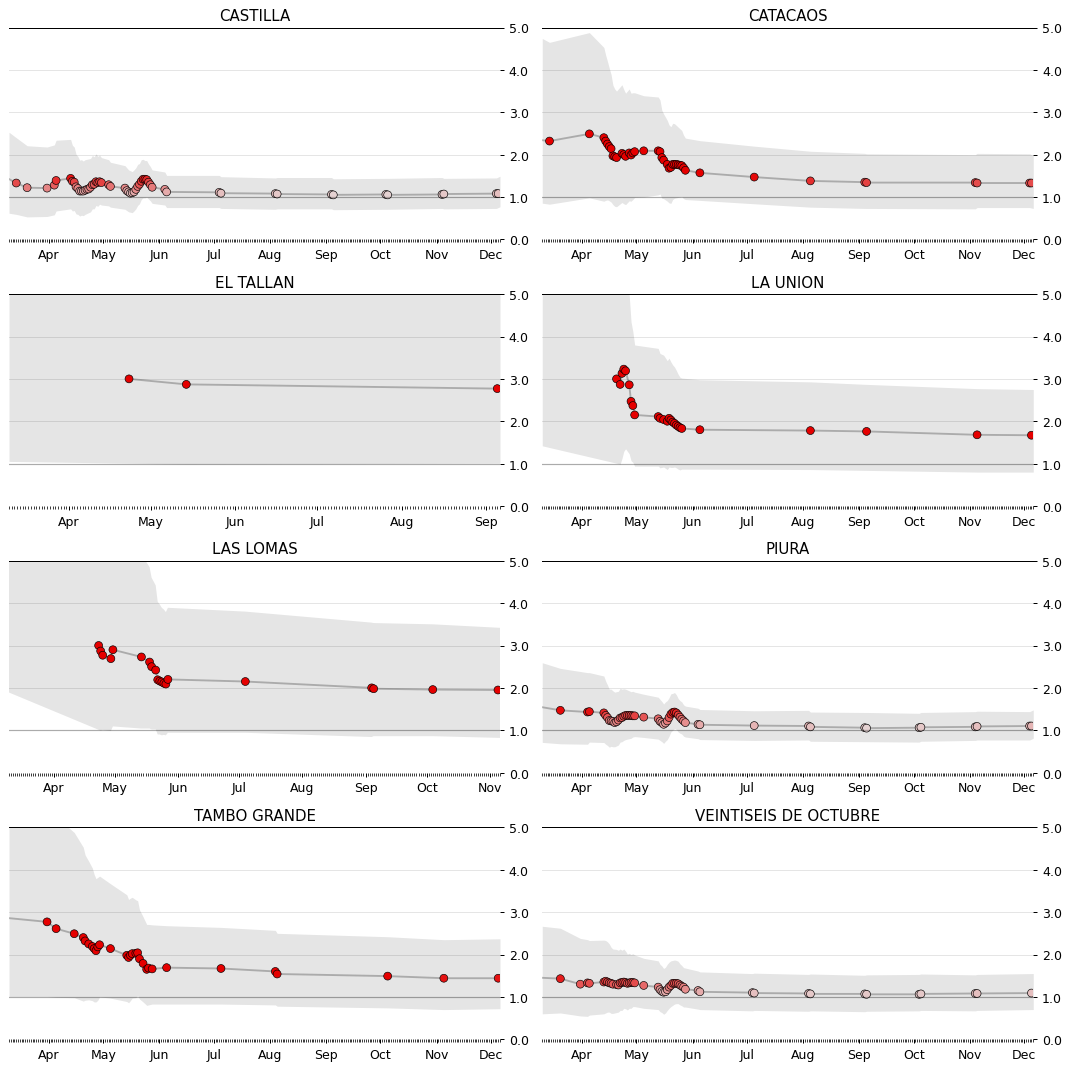

In [13]:
### plotting - Rt vs time for all states ###

def plot_rt_states():

    # number of columns and rows for plotting
    #N_COLS = 5
    N_COLS = 2
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(12, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()

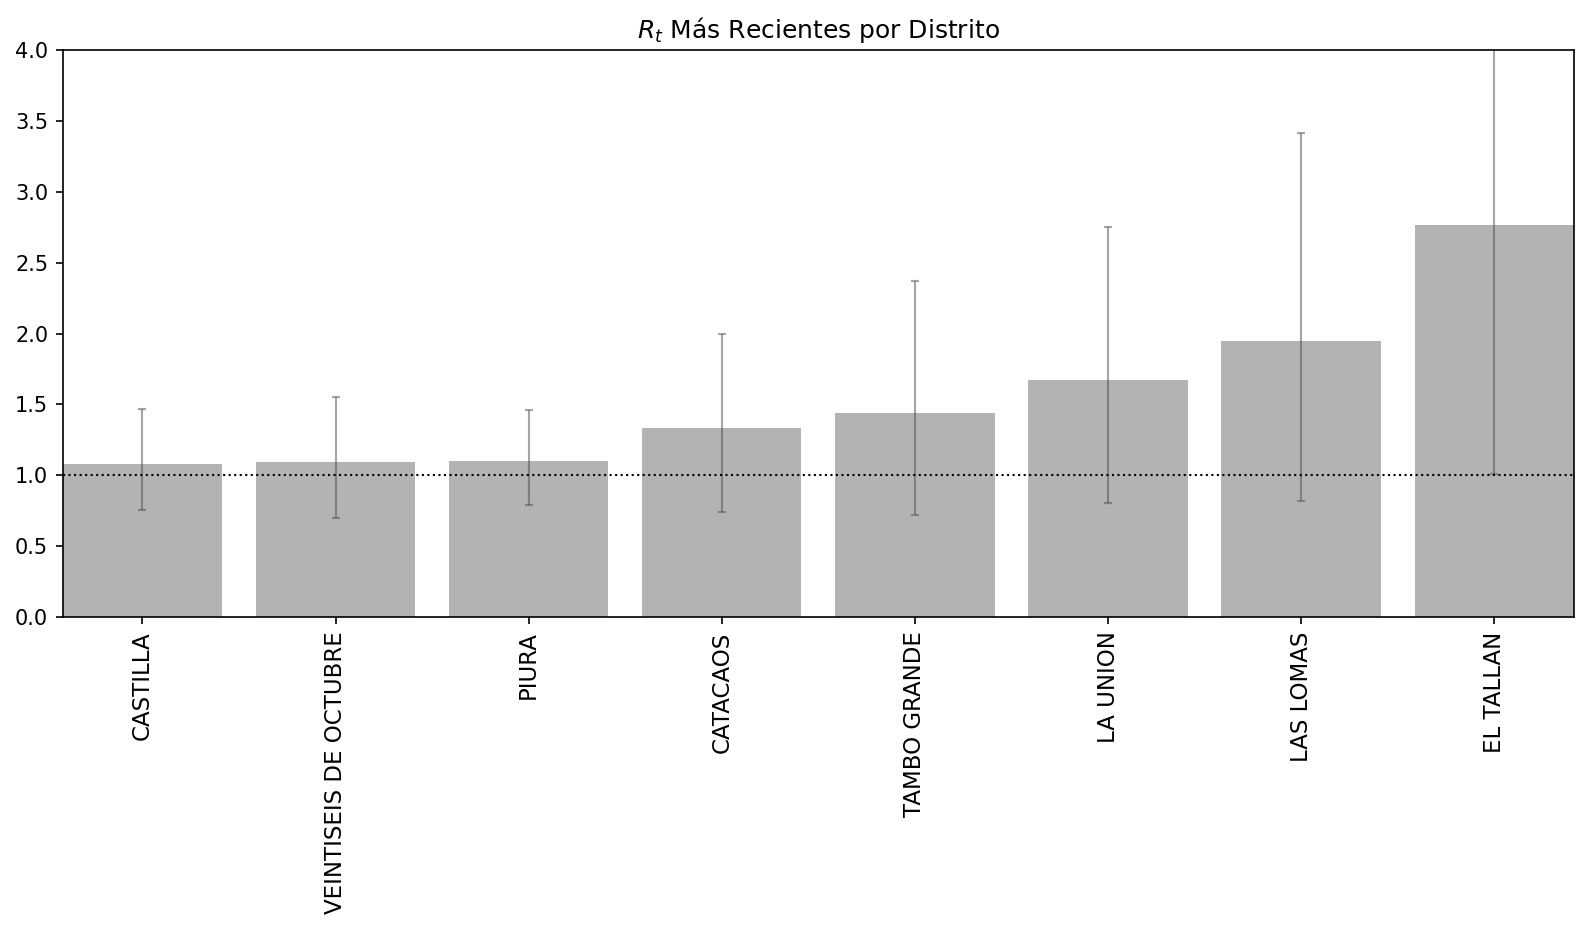

In [16]:
### plotting - state comparison ###

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(13,5));
final_results.to_csv(f'final_results{date.today()}.csv')